In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [3]:
bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']

In [4]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [5]:
from datetime import time, timedelta
from dateutil.relativedelta import relativedelta

In [45]:
def backtest(stock_price_df, coeffs, entryZscore, exitZscore, stopLossZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 30).mean()
    df['std_30'] = df['spread'].rolling(window = 30).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore) & (df.z_score > - stopLossZscore)
    df['long_exit'] = ((df.z_score > - exitZscore) | (df.z_score < - stopLossZscore)) & ( df.z_score.shift(1) < - exitZscore) 
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore) & (df.z_score < stopLossZscore)
    df['short_exit'] = ((df.z_score < exitZscore) | (df.z_score > stopLossZscore)) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_long'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe, df['spread']

In [7]:
start = datetime(2022, 1, 1)
end = datetime(2025, 1, 1)

bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']


df = yf.download(bank_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  8 of 8 completed


In [8]:
df.to_csv('bank_test_5yr.csv')

In [9]:
df_test = pd.read_csv('bank_test_5yr.csv', parse_dates=True, index_col='Date')

In [10]:
df_test

,AXISBANK.NS,BANKBARODA.NS,CANBK.NS,HDFCBANK.NS,ICICIBANK.NS,INDUSINDBK.NS,KOTAKBANK.NS,SBIN.NS
Date,,,,,,,,
2022-01-03,696.349976,83.800003,41.090000,1519.650024,764.700012,912.299988,1824.449951,470.799988
2022-01-04,709.150024,83.900002,41.310001,1528.550049,772.849976,904.400024,1852.599976,483.500000
2022-01-05,726.900024,84.900002,42.200001,1564.849976,788.049988,903.950012,1922.150024,492.399994
2022-01-06,730.299988,86.599998,42.500000,1539.750000,785.049988,921.700012,1891.900024,491.700012
2022-01-07,730.599976,87.599998,42.459999,1550.550049,793.250000,922.250000,1904.250000,491.250000
...,...,...,...,...,...,...,...,...
2024-12-24,1078.900024,244.949997,100.550003,1798.099976,1297.250000,935.299988,1749.050049,812.049988
2024-12-26,1076.699951,246.679993,101.029999,1790.750000,1297.349976,931.950012,1752.800049,812.450012
2024-12-27,1077.449951,244.990005,100.360001,1798.250000,1307.550049,953.400024,1759.900024,799.650024


2022-01-01 00:00:00


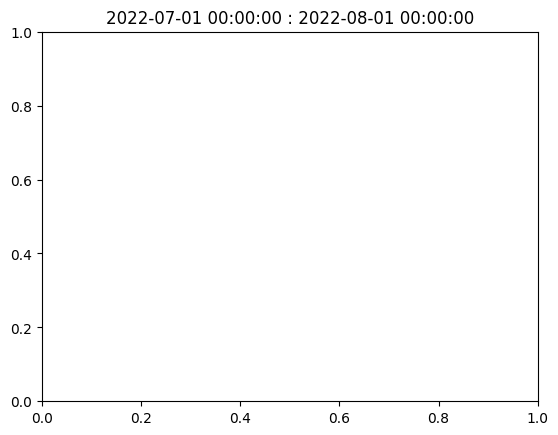

2022-02-01 00:00:00


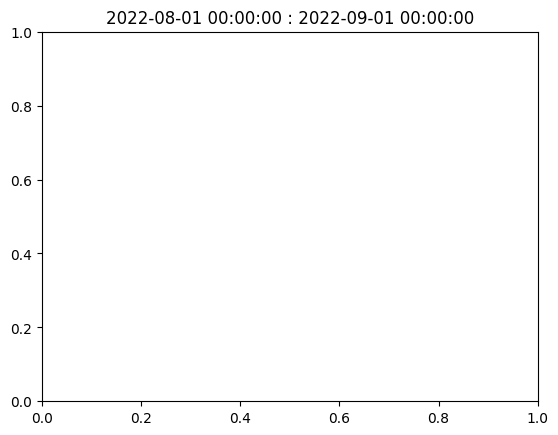

2022-03-01 00:00:00


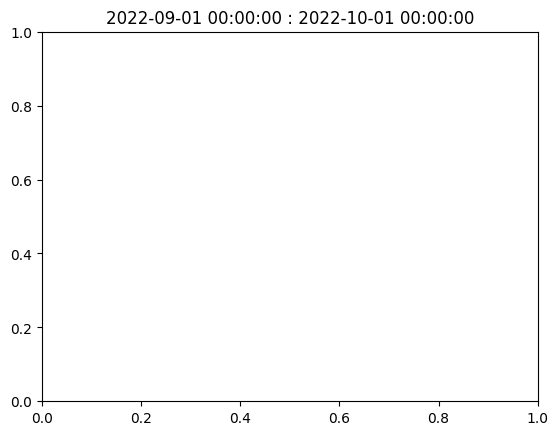

2022-04-01 00:00:00


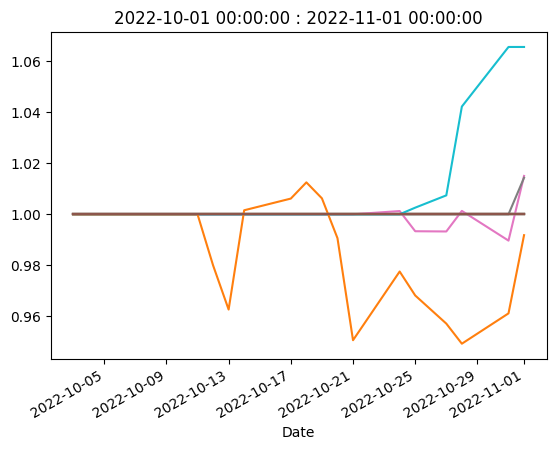

2022-05-01 00:00:00


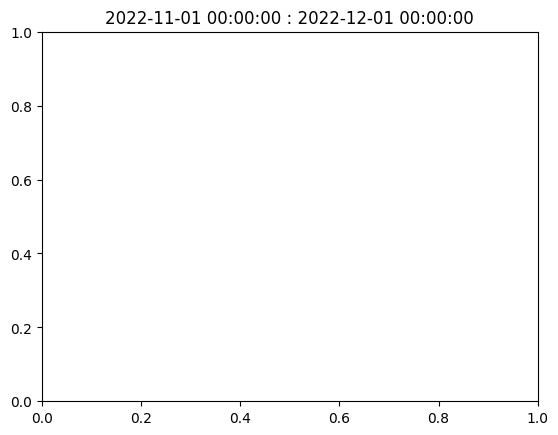

2022-06-01 00:00:00


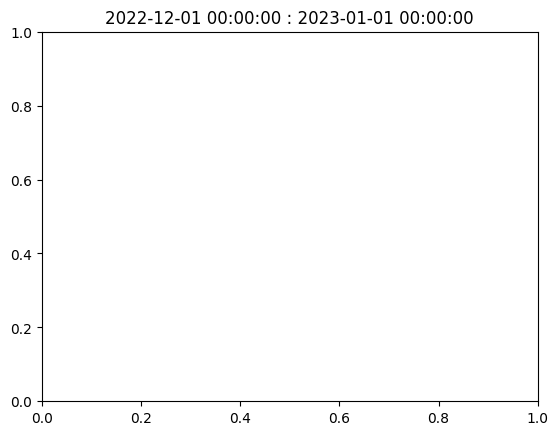

2022-07-01 00:00:00


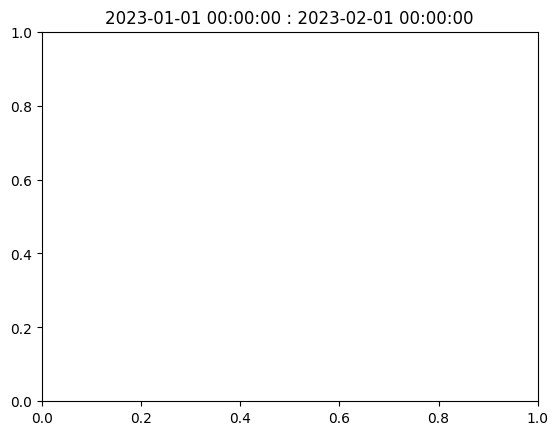

2022-08-01 00:00:00


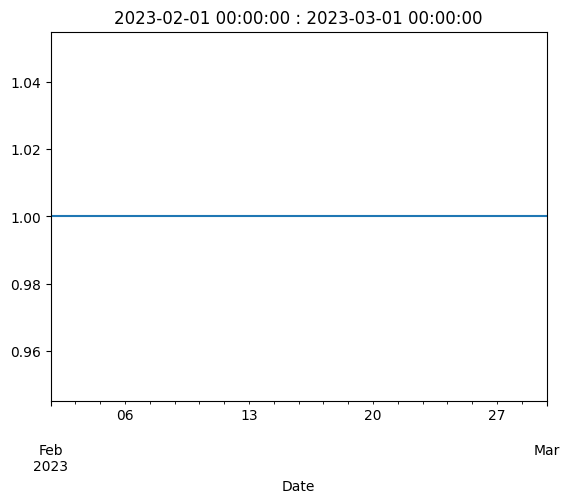

2022-09-01 00:00:00


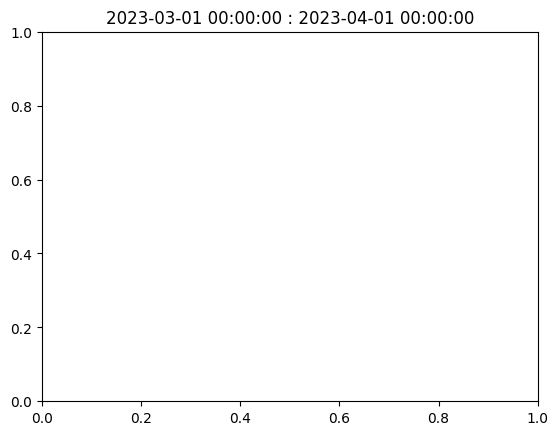

2022-10-01 00:00:00


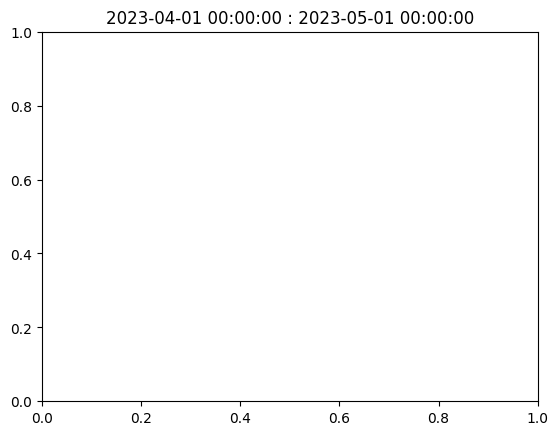

2022-11-01 00:00:00


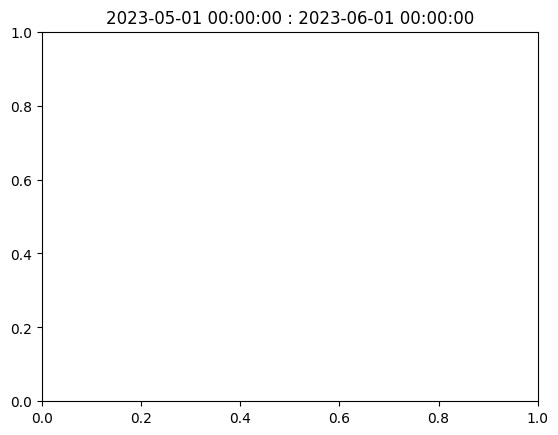

2022-12-01 00:00:00


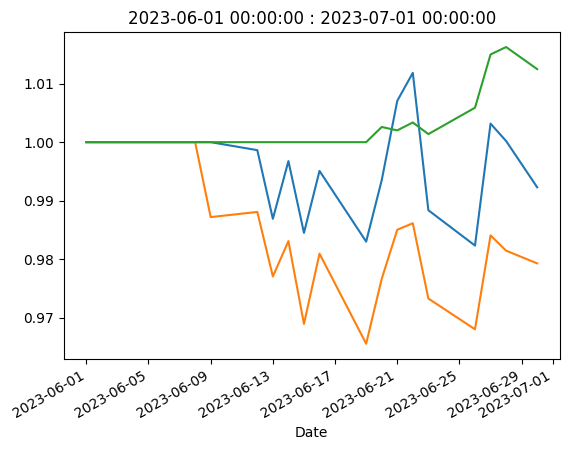

2023-01-01 00:00:00


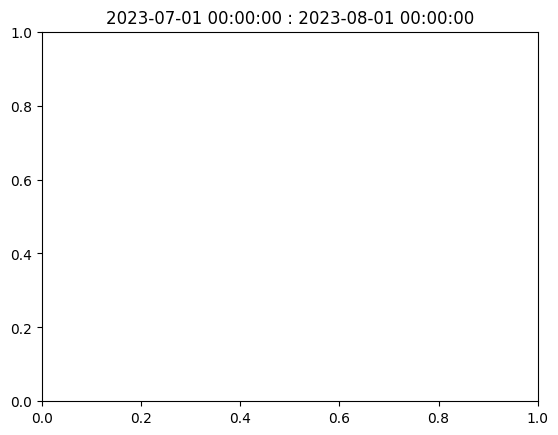

2023-02-01 00:00:00


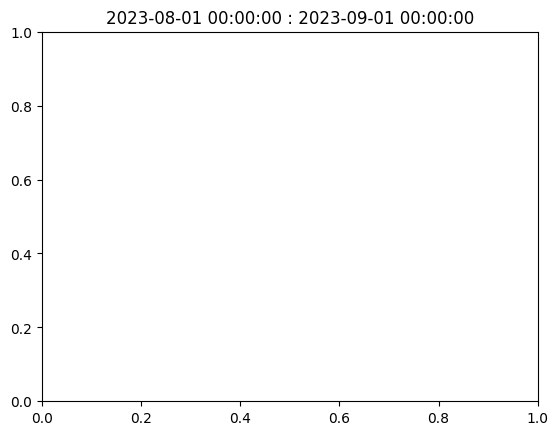

2023-03-01 00:00:00


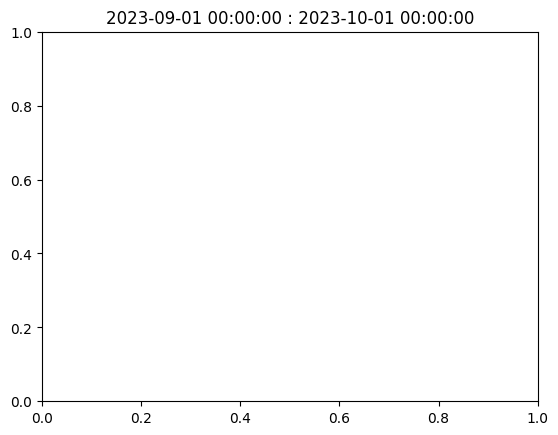

2023-04-01 00:00:00


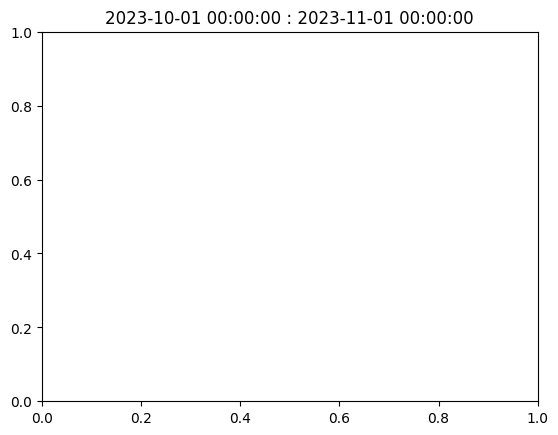

2023-05-01 00:00:00


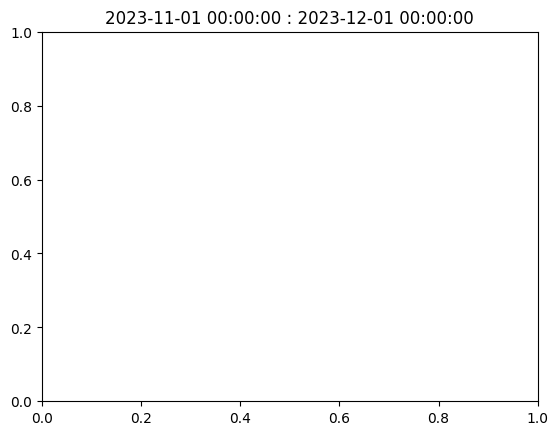

2023-06-01 00:00:00


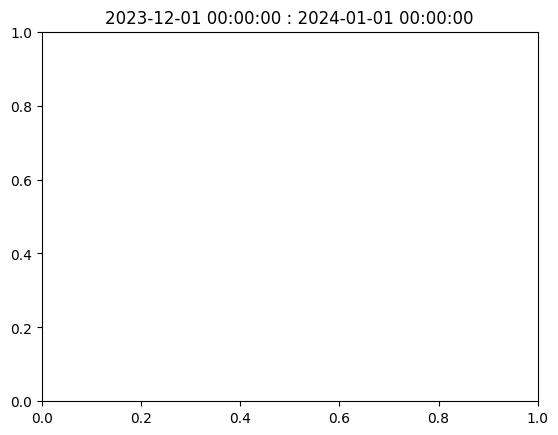

2023-07-01 00:00:00


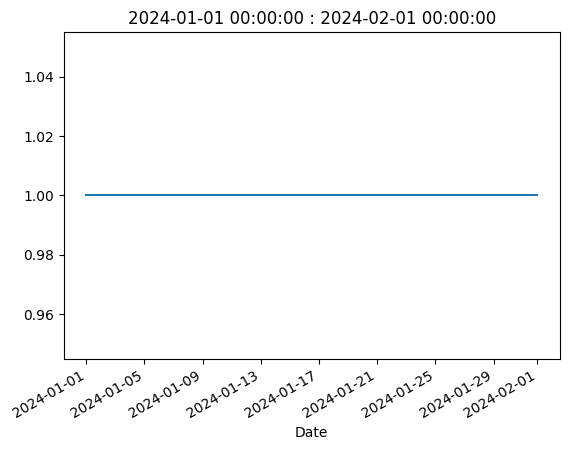

2023-08-01 00:00:00


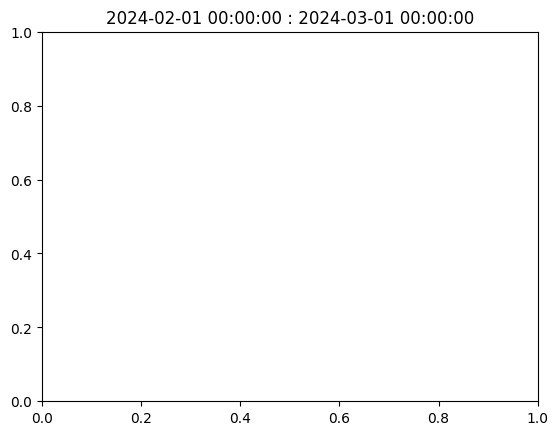

2023-09-01 00:00:00


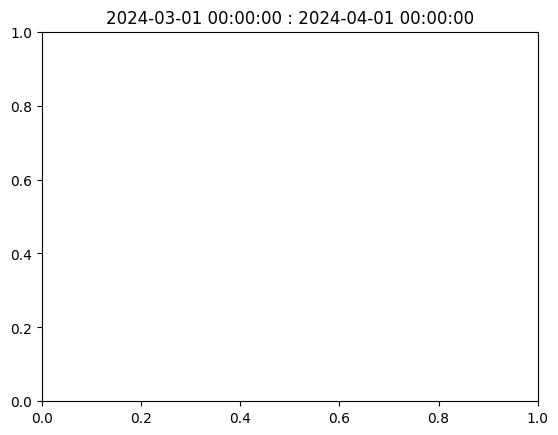

2023-10-01 00:00:00


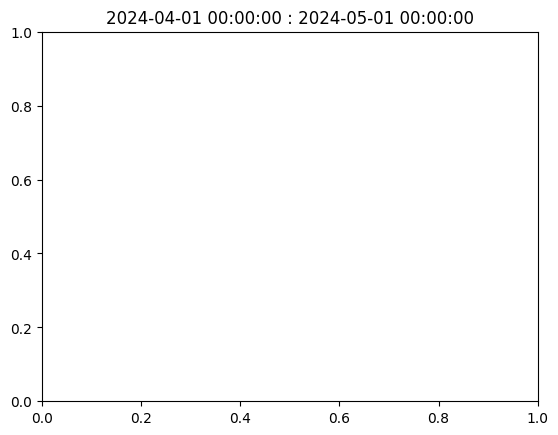

2023-11-01 00:00:00


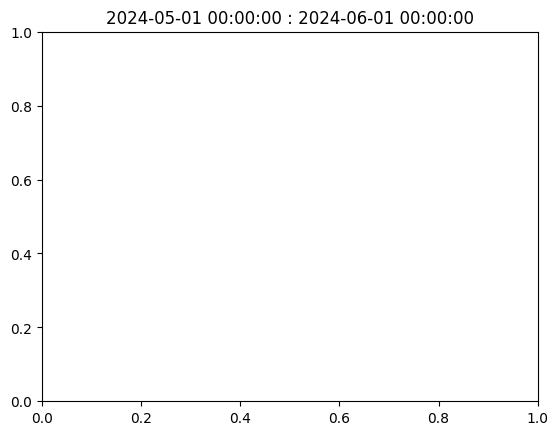

2023-12-01 00:00:00


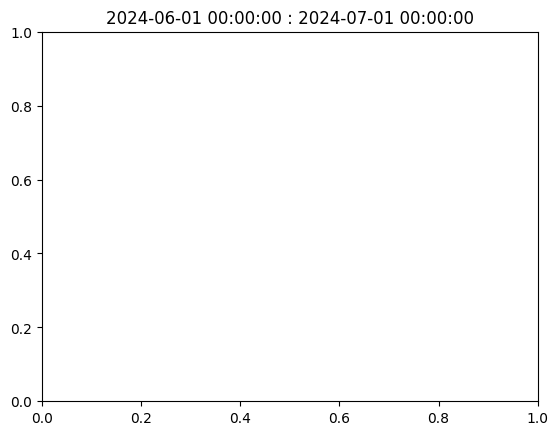

2024-01-01 00:00:00


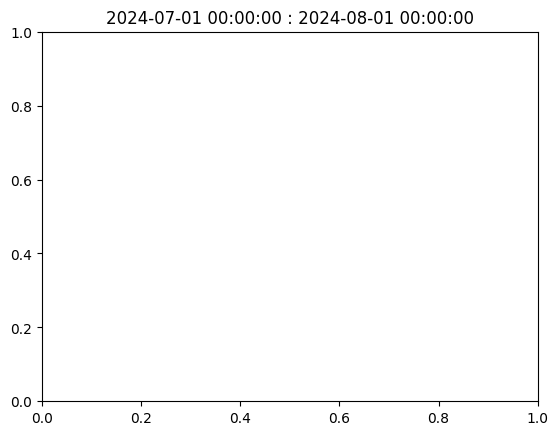

2024-02-01 00:00:00


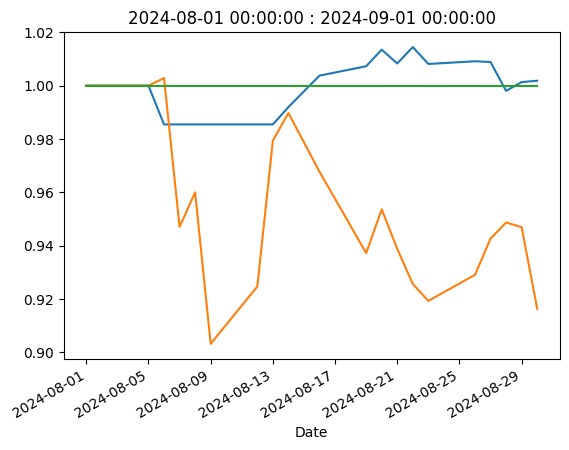

2024-03-01 00:00:00


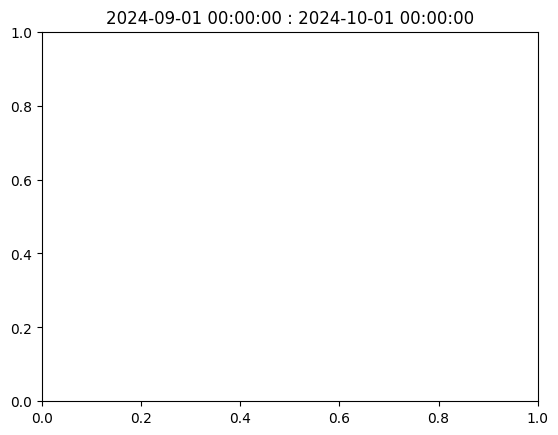

2024-04-01 00:00:00


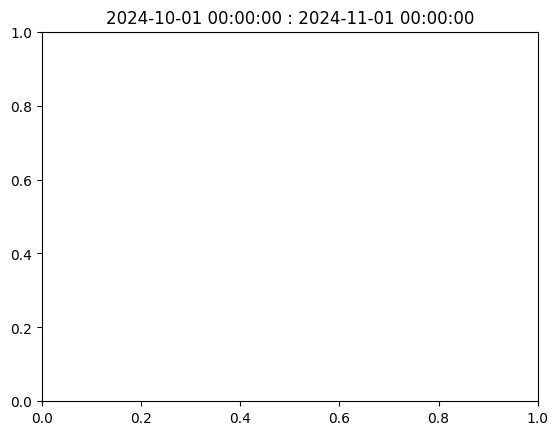

2024-05-01 00:00:00


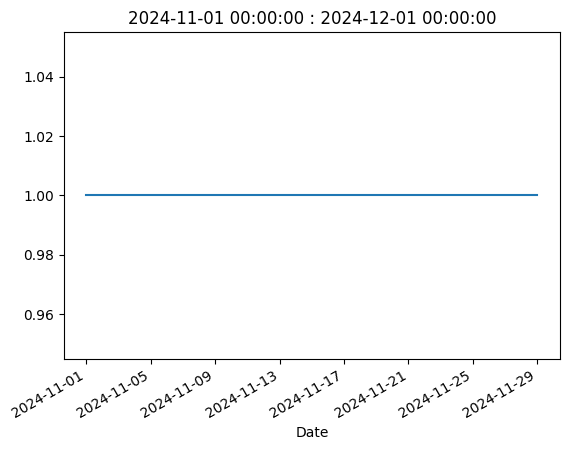

2024-06-01 00:00:00


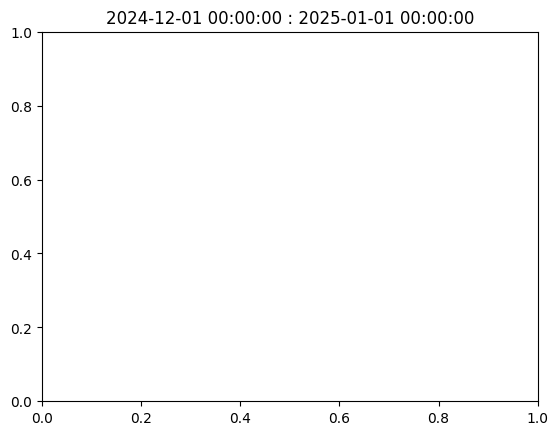

2024-07-01 00:00:00


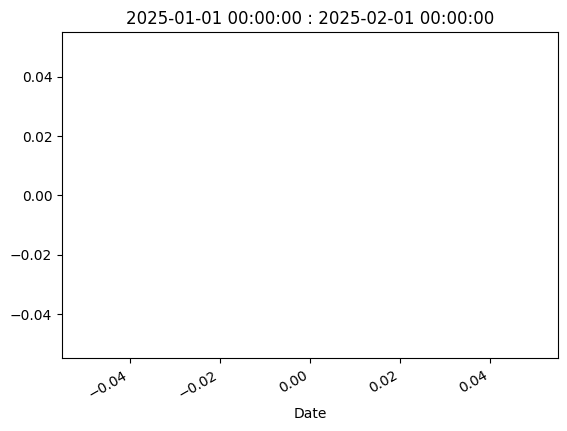

2024-08-01 00:00:00


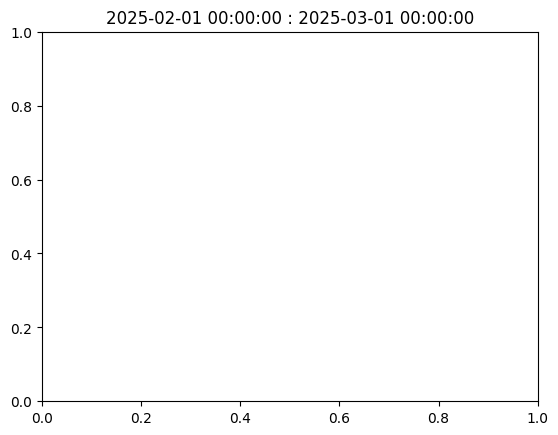

2024-09-01 00:00:00


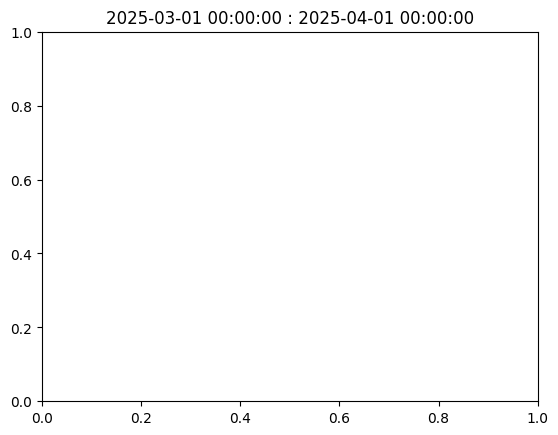

2024-10-01 00:00:00
index 0 is out of bounds for axis 0 with size 0


In [ ]:
start_check = datetime(2022, 1, 1)
over = False
net_ret = []
while start_check <= datetime(2024,12,1):
    print(start_check)
    end_check = start_check + relativedelta(months=6)
    n = len(bank_tickers)
    poss_comb_bank = {}
    for i in range(n - 1):
        for j in range(i + 1, n):
            bk_group = bank_tickers[i:j + 1]
            try:
                res = coint_johansen(df_test[bk_group].loc[start_check:end_check], det_order=1, k_ar_diff=1)
            except Exception as e:
                print(e)
                over = True
                break
            if res.lr1[0] > res.cvt[0][2] and res.lr2[0] > res.cvm[0][2]:
                poss_comb_bank[(i, j + 1)] = res.evec[0]
                
    bank_ind = list(poss_comb_bank.keys())
    
    # df_test['temp'] = 0

    month_ret = 0

    for comb in bank_ind:
        coeff_vec = poss_comb_bank[comb]
        group = bank_tickers[comb[0] : comb[1]]
        # print(comb)
        try:
            res = backtest(df_test[end_check - relativedelta(days=42): end_check + relativedelta(months=1)][group], coeff_vec, 2, 0, 3)
            res[0].loc[end_check: end_check + relativedelta(months = 1)].plot()
            # df_test['temp'] += res[0]
            month_ret += res[0][-1] - 1
        except Exception as e:
            print(e)
            over = True 
            break 
    
    if over:
        break
    else:
        # df_test['temp'] /= len(bank_ind)
        # df_test['temp'].loc[end_check: end_check + relativedelta(days = 42)].plot()
        plt.title(f'{end_check} : {end_check + relativedelta(months = 1)}')
        plt.show()
    start_check = start_check + relativedelta(months = 1)
    net_ret.append(month_ret)
    

In [66]:
sum = 0
for i in net_ret:
    if abs(i) < 19999:
        sum += i
        print(i)

0
0
0
0.08680925313827292
0
0
0
0.0
0
0
0
-0.015966319730074674
0
0
0
0
0
0
0.0
0
0
0
0
0
0
-0.08182615574704966
0
0
0.0
0
0.0
0
0


In [67]:
sum

-0.010983222338851406

In [36]:
df_train = pd.read_csv('pharma_test.csv', parse_dates=True, index_col='Date')

In [37]:
pharma_tickers = [
    "SUNPHARMA.NS", "DRREDDY.NS", "CIPLA.NS", "DIVISLAB.NS",
    "AUROPHARMA.NS", "BIOCON.NS", "LUPIN.NS", "TORNTPHARM.NS",
    "ZYDUSLIFE.NS", "GLENMARK.NS"
]

2022-07-01 00:00:00


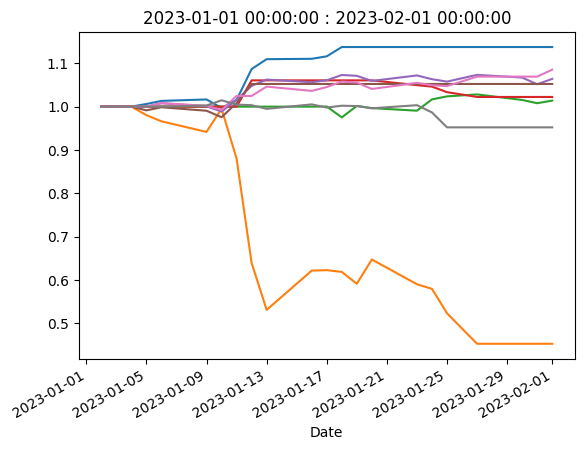

2022-08-01 00:00:00


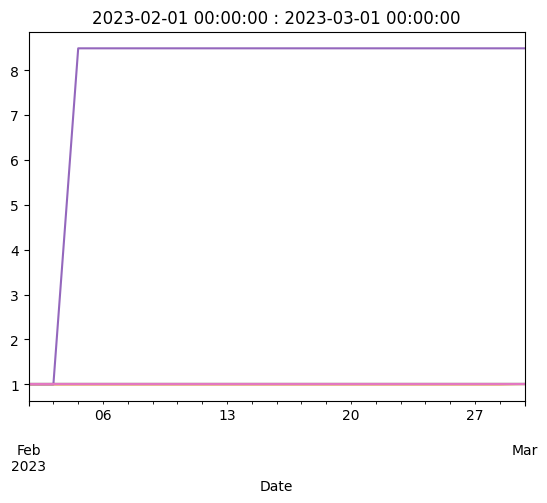

2022-09-01 00:00:00


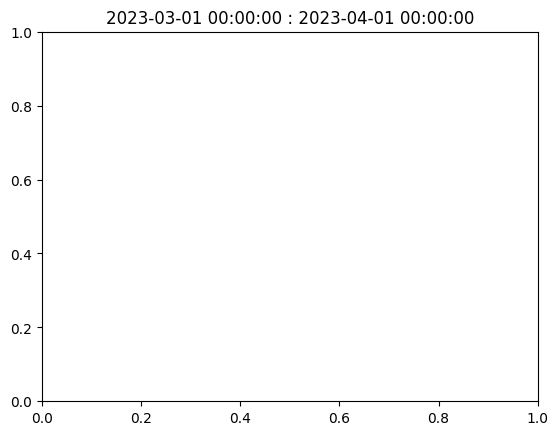

2022-10-01 00:00:00


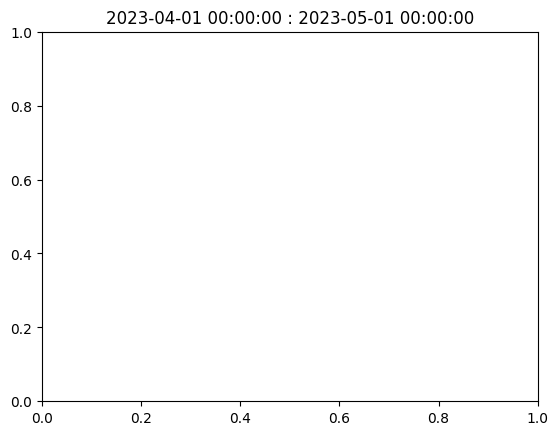

2022-11-01 00:00:00


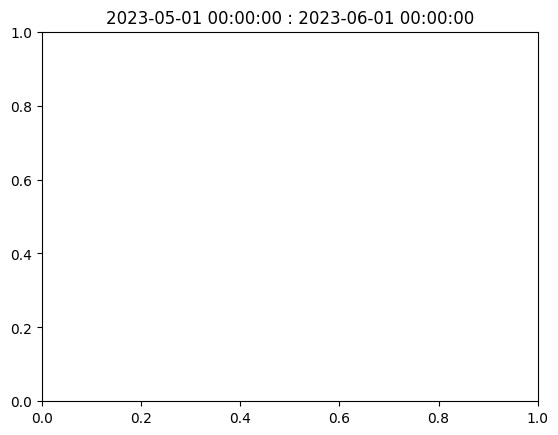

2022-12-01 00:00:00


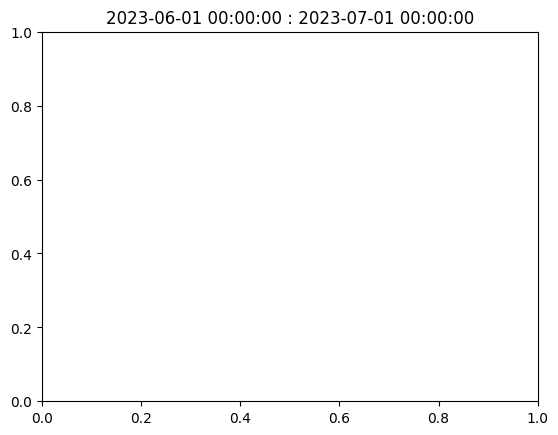

2023-01-01 00:00:00


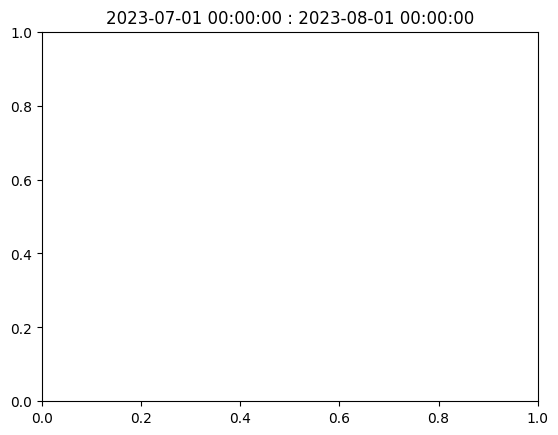

2023-02-01 00:00:00


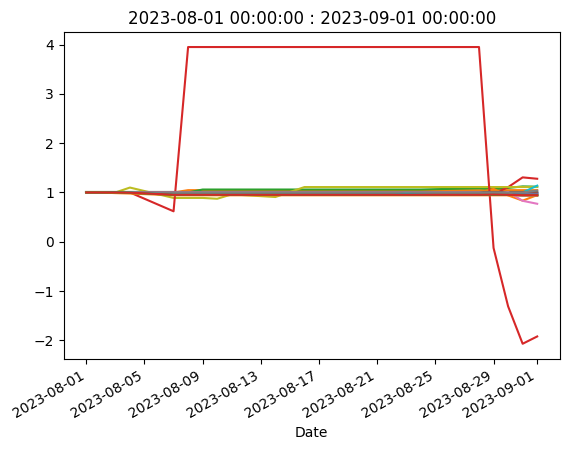

2023-03-01 00:00:00


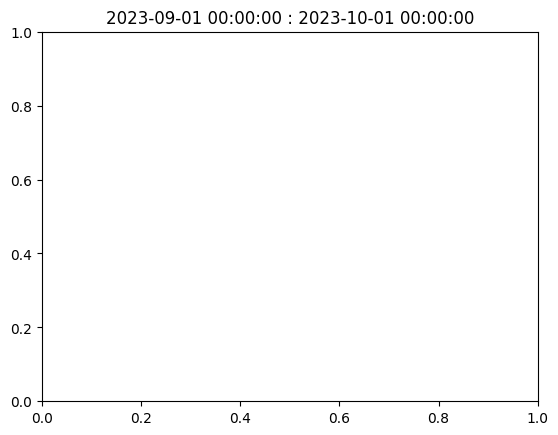

2023-04-01 00:00:00


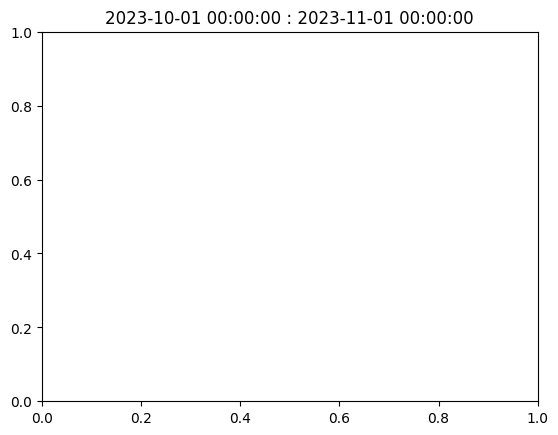

2023-05-01 00:00:00


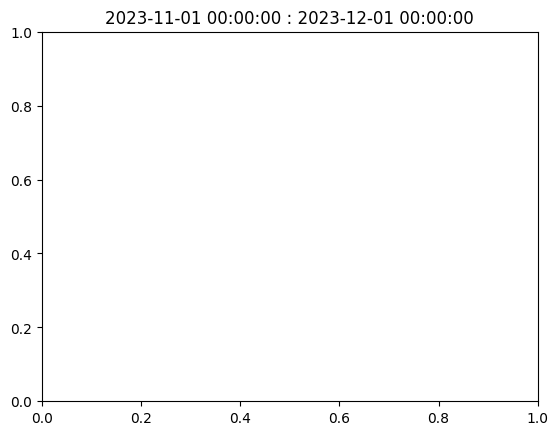

2023-06-01 00:00:00


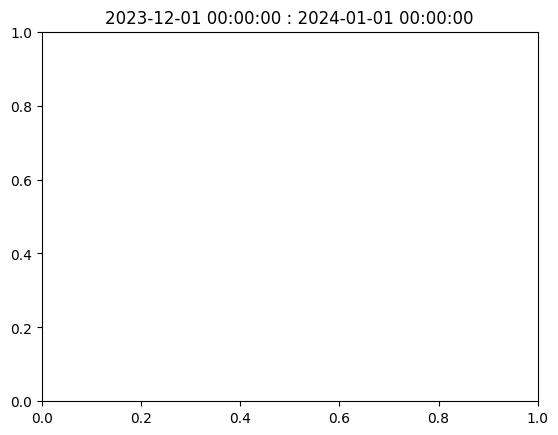

2023-07-01 00:00:00


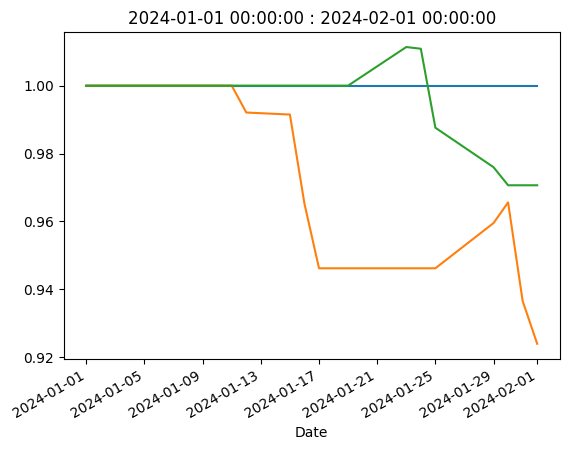

2023-08-01 00:00:00


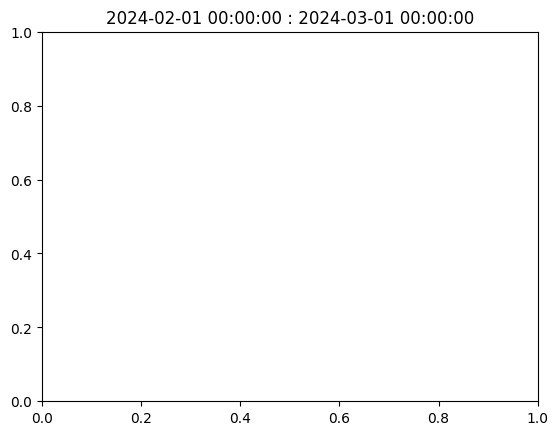

2023-09-01 00:00:00


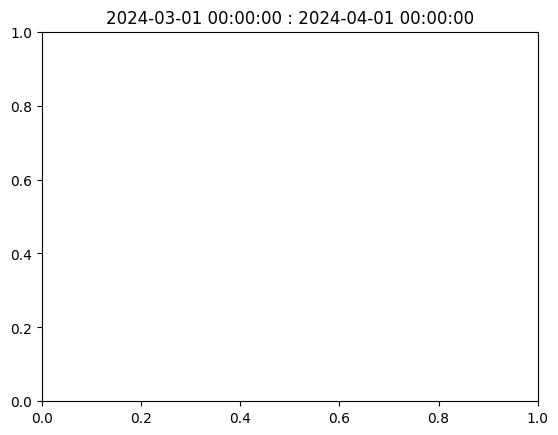

2023-10-01 00:00:00


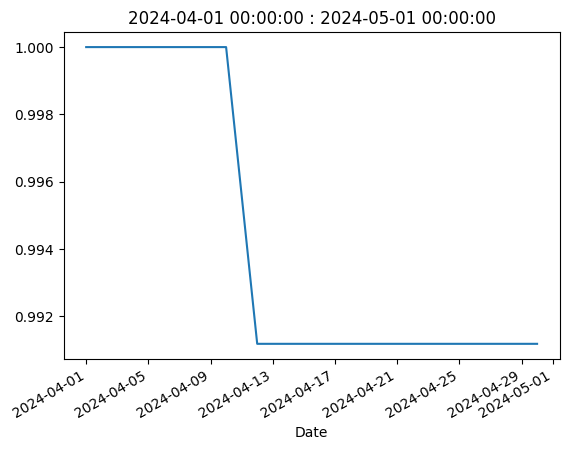

2023-11-01 00:00:00


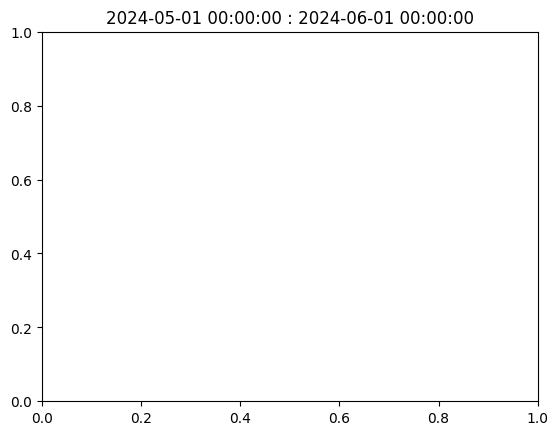

2023-12-01 00:00:00


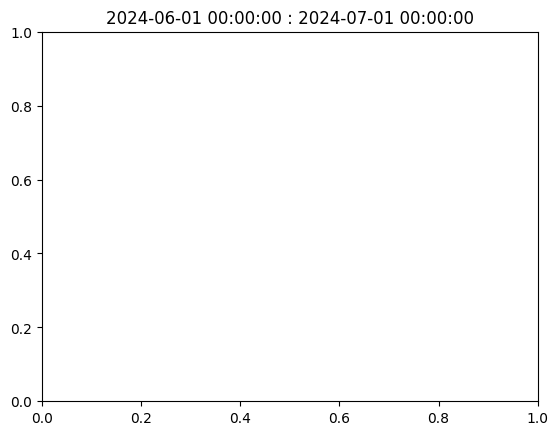

2024-01-01 00:00:00


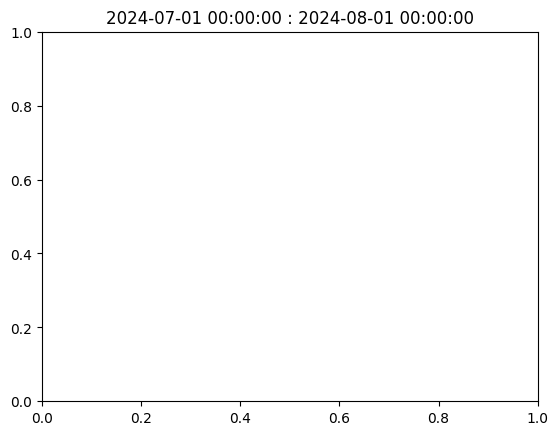

2024-02-01 00:00:00


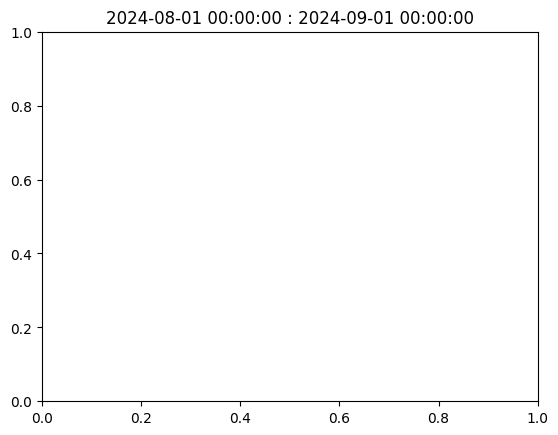

2024-03-01 00:00:00


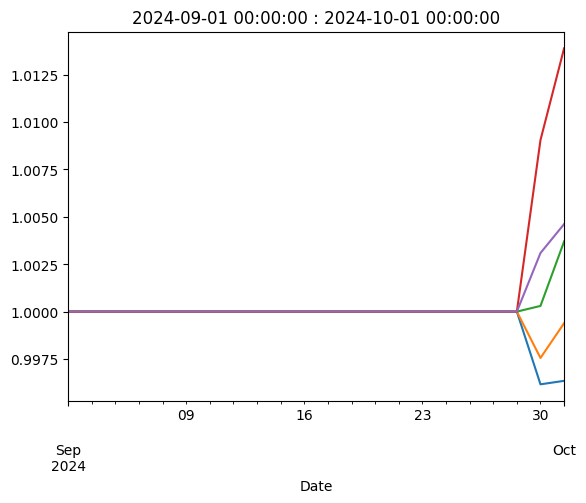

2024-04-01 00:00:00


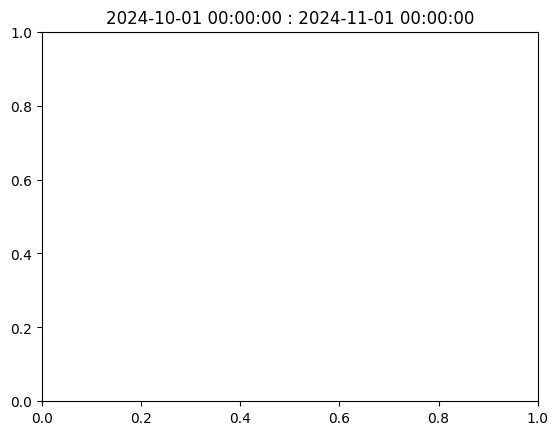

2024-05-01 00:00:00


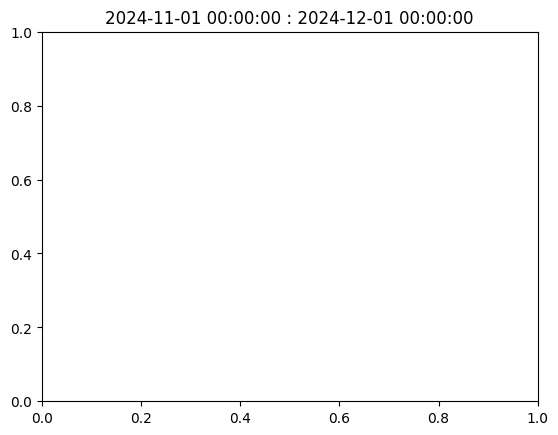

2024-06-01 00:00:00


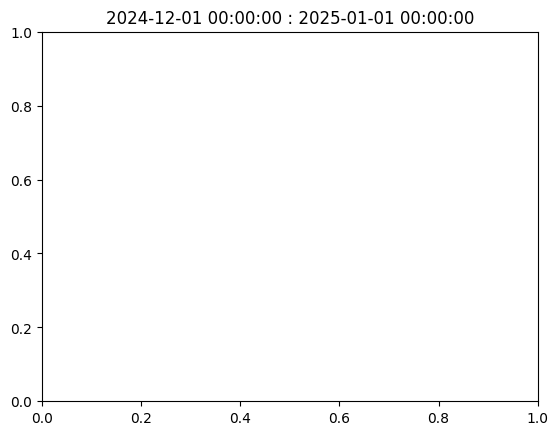

2024-07-01 00:00:00


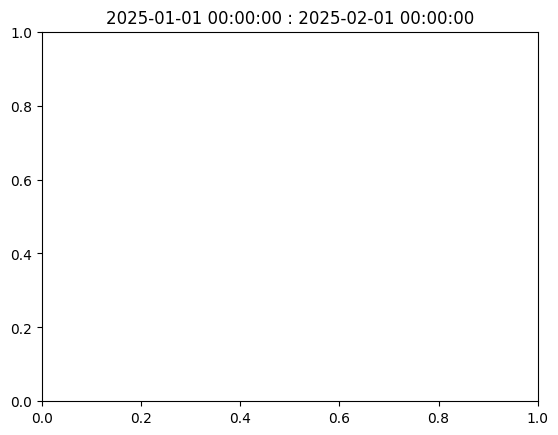

2024-08-01 00:00:00


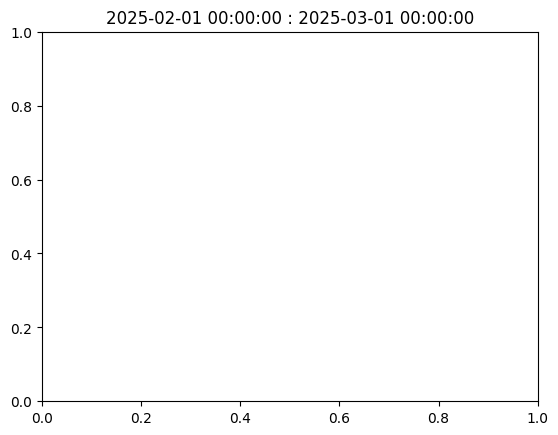

2024-09-01 00:00:00


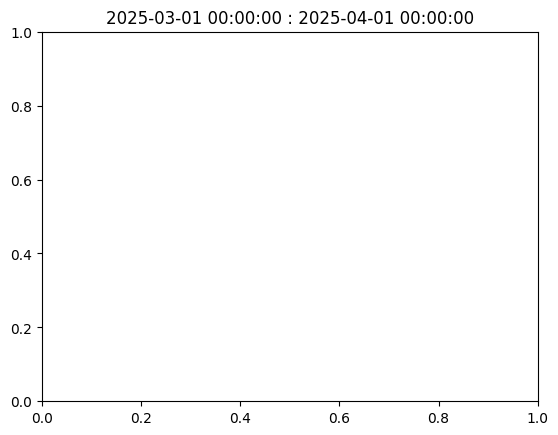

2024-10-01 00:00:00
index 0 is out of bounds for axis 0 with size 0


In [ ]:
start_check = datetime(2022, 7, 1)
over = False
net_ret = []
while start_check <= datetime(2024,12,1):
    print(start_check)
    end_check = start_check + relativedelta(months=6)
    n = len(pharma_tickers)
    poss_comb_bank = {}
    for i in range(n - 1):
        for j in range(i + 1, n):
            bk_group = pharma_tickers[i:j + 1]
            try:
                res = coint_johansen(df_train[bk_group].loc[start_check:end_check], det_order=1, k_ar_diff=1)
            except Exception as e:
                print(e)
                over = True
                break
            if res.lr1[0] > res.cvt[0][2] and res.lr2[0] > res.cvm[0][2]:
                poss_comb_bank[(i, j + 1)] = res.evec[0]
                
    bank_ind = list(poss_comb_bank.keys())
    
    # df_test['temp'] = 0

    month_ret = 0

    for comb in bank_ind:
        coeff_vec = poss_comb_bank[comb]
        group = pharma_tickers[comb[0] : comb[1]]
        # print(comb)
        try:
            res = backtest(df_train[end_check - relativedelta(days=42): end_check + relativedelta(months=1)][group], coeff_vec, 1, 0, 2)
            res[0].loc[end_check: end_check + relativedelta(months = 1)].plot()
            # df_test['temp'] += res[0]
            month_ret += res[0][-1] - 1
        except Exception as e:
            print(e)
            over = True 
            break 
    
    if over:
        break
    else:
        # df_test['temp'] /= len(bank_ind)
        # df_test['temp'].loc[end_check: end_check + relativedelta(days = 42)].plot()
        plt.title(f'{end_check} : {end_check + relativedelta(months = 1)}')
        plt.show()
    start_check = start_check + relativedelta(months = 1)
    net_ret.append(month_ret)
    

In [63]:
sum = 0
for i in net_ret:
    if abs(i) < 200:
        sum += i
        print(i)

-0.2196518196914674
7.493910879746891
0
0
0
0
0
-2.968163895018336
0
0
0
0
-0.10534150490524674
0
0
-0.008818516664606202
0
0
0
0
0.01794566110821727
0
0
0
0
0
0


In [64]:
sum

4.209880804575452